## Практическое задание к уроку № 7 по теме "Классификация с помощью KNN. Кластеризация K-means".

#### Задание 1.  
*К алгоритму kNN, представленному на уроке, реализуйте добавление весов для соседей по любому из показанных на уроке принципов.  
Сравните точность нового алгоритма с исходным при разных значениях `k`.*

Возмём код с урока и преобразуем его:

In [1]:
%matplotlib inline

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [2]:
def l2_norm(x1, x2):
    return np.sqrt(sum((x1 - x2)**2))

In [3]:
def knn(x_train, y_train, x_test, k, weighted=None):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = l2_norm(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # отберем k ближайших соседей
        k_neighbours = sorted(test_distances)[:k]
                
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in np.unique(y_train)}
        
        # Подсчитаем суммарный вес разных классов среди ближайших соседей
        for idx, d in enumerate(k_neighbours):
            if weighted == 'order':
                weight = 1 / (idx + 1)
            elif weighted == 'distance':
                weight = 0.5**d[0]
            else:
                weight = 1
            classes[d[1]] += weight
            
        # Записываем в список ответов наиболее весомый класс
        answers.append(max(classes, key=classes.get))
    return answers

In [4]:
def calc_accuracy(y, y_pred):
    return (y == y_pred).sum() / y.shape[0]

Создадим датасет из 1000 объектов для более точного сравнения:

In [5]:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, 
                           n_classes=3, n_redundant=0, flip_y=0.05,
                           n_clusters_per_class=1, random_state=29)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=29)

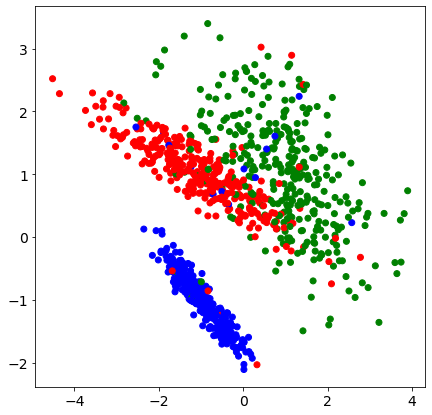

In [7]:
plt.rcParams.update({'font.size': 14})

cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

plt.show()

Сравним работу алгоритма с расчётом весов и без него:

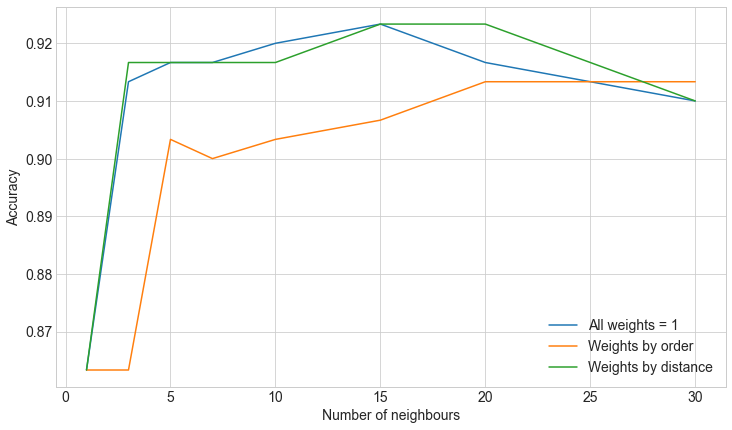

In [8]:
plt.figure(figsize=(12, 7))
plt.style.use('seaborn-whitegrid')

k = (1, 3, 5, 7, 10, 15, 20, 30)
knn_ones = []
knn_weighted_ord = []
knn_weighted_dist = []

for i in k:
    y_pred = knn(X_train, y_train, X_test, k=i, weighted=None)
    knn_ones.append(calc_accuracy(y_test, y_pred))
    
    y_pred_o = knn(X_train, y_train, X_test, k=i, weighted='order')
    knn_weighted_ord.append(calc_accuracy(y_test, y_pred_o))

    y_pred_d = knn(X_train, y_train, X_test, k=i, weighted='distance')
    knn_weighted_dist.append(calc_accuracy(y_test, y_pred_d))
    
plt.plot(k, knn_ones, label='All weights = 1')
plt.plot(k, knn_weighted_ord, label='Weights by order')
plt.plot(k, knn_weighted_dist, label='Weights by distance')
plt.xlabel('Number of neighbours')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

Было проведено сравнение работы алгоритма kNN при различных способах расчёта весов у соседей. Веса рассчитывались в зависимости от порядка расположения соседа или в зависимости от расстояния до соседа. Построен график точности алгоритма при различных значениях гиперпараметра k. Также на графике показана работа алгоритма без расчёта весов (все веса равны 1).  
В нашем случае алгоритм с методом расчёта весов в зависимости от порядка расположения показал себя хуже всего. Алгоритм без расчёта весов и алгоритм с расчётом весов в зависимости от расстояния оказались схожи по точности. Наивысшую точность они показали при количестве соседей, равном 15.  
Можно сделать вывод, что механизм расчёта весов в алгоритме kNN является параметром тонкой настройки, так как, во-первых, в нашем случае алгоритм совсем без расчёта весов показал себя не хуже, а во-вторых, сами формулы расчёта весов многообразны и можно долго подбирать коэффициенты в этих формулах. В конечном итоге, всё будет зависеть от конкретной задачи.

#### Задание 2.  
*Напишите функцию подсчета метрики качества кластеризации как среднее квадратичное внутрикластерное расстояние и  
постройте график ее зависимости от количества кластеров `k` (взять от 1 до 10) для выборки данных из данного урока  
(создать датасет, как в методичке).*

Возьмём алгоритм из урока, немного модифицируем его :

In [9]:
def kmeans(data, k, max_iterations=10, min_distance=1e-4):
       
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # Создадим словарь для кластеризации
        clusters = {i: [] for i in range(k)}
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [l2_norm(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            i = distances.index(min(distances))
            clusters[i].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for i in clusters:
            centroids[i] = np.mean(clusters[i], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for i in range(len(centroids)):
            if l2_norm(centroids[i], old_centroids[i]) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, clusters

Напишем функцию подсчёта метрики:

In [10]:
def cluster_metrics(centroids, clusters):
    result = 0
    for i in clusters:
        result += sum(l2_norm(x, centroids[i])**2 for x in clusters[i]) / len(clusters[i])
    return result

Возьмём датасет из методички:

In [11]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=100, random_state=1)

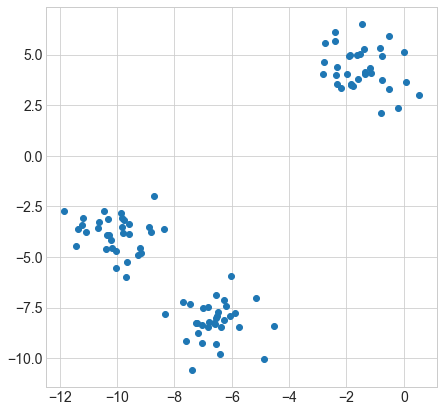

In [12]:
plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1]);

Произведём кластеризацию при различных значениях k и изобразим  
метрику на графике:

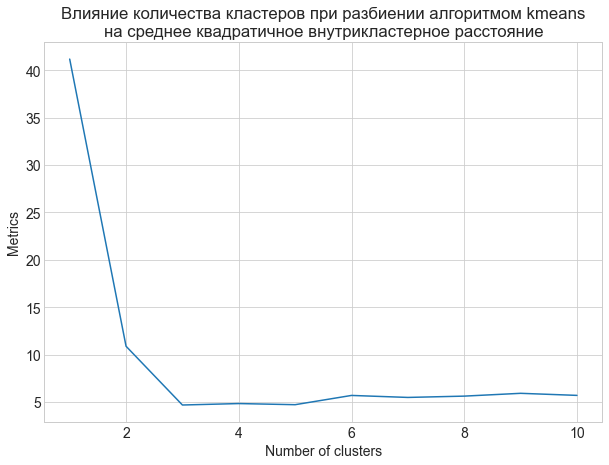

In [13]:
plt.figure(figsize=(10,7))

metrics = []
ks = range(1, 11)

for k in ks:
    centroids, clusters = kmeans(X, k, max_iterations=50)
    metrics.append(cluster_metrics(centroids, clusters))

plt.plot(ks, metrics)
plt.title('Влияние количества кластеров при разбиении алгоритмом kmeans\n'
          'на среднее квадратичное внутрикластерное расстояние')
plt.xlabel('Number of clusters')
plt.ylabel('Metrics')

plt.show()

In [14]:
for i in range(3, 6):
    print(f'{i} clusters: {metrics[i-1]:.2f}')

3 clusters: 4.68
4 clusters: 4.83
5 clusters: 4.72


В нашем случае наилучшую метрику показала модель с 3-мя кластерами, что неудивительно, глядя на визуализацию исходных данных выше.  
Хотя и модели с 4 и 5 кластерами оказались близки к лучшему результату.